- 필요한 패키지 import

In [1]:
import tensorflow as tf

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

- cat-dogs 데이터등 데이터 , 리소스 관리 관련 패키지 설치 필요

- pip install tensorflow-datasets

In [4]:
import tensorflow_datasets as tfds

In [5]:
tfds.disable_progress_bar()

- train(80%), validation(10%), test(10%) 

In [6]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Shuffling and writing examples to /Users/agun/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete2GV5IA/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /Users/agun/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


 - 이미지를 학습할수 있는 구조에 맞게 160 X 160 으로 리사이징 하고 정규화 

In [8]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [10]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [11]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

 - mobileNet version 2 model의 load
 - 이때 분류기는 자체 학습하기 때문에 include_top 을 False 로 한다.

In [12]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [13]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


- 가져온 모델의 특징값들을 학습하지 않고 그대로 사용하기 때문에 model을 Freeze 시킨다

In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

- 피처 블록에서 예측을 생성하려면 tf.keras.layers.GlobalAveragePooling2D 레이어를 사용하여 피처를 이미지 당 하나의 1280 요소 벡터로 변환하여 공간 5x5 공간 위치에서 평균을 구함
- 최종적으로 분류기에서 사용하는 Dense layer 정의

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

- 기존에 학습된 model에 분류기를 추가

In [18]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

- 학습 loss와 learning rate를 설정

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 5s 251ms/step - loss: 1.1068 - accuracy: 0.2891


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.11
initial accuracy: 0.29


In [24]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 208s 357ms/step - loss: 0.4086 - accuracy: 0.7887 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 206s 353ms/step - loss: 0.2061 - accuracy: 0.9151 - val_loss: 0.1420 - val_accuracy: 0.9273
Epoch 3/10
582/582 [==============================] - 209s 359ms/step - loss: 0.1650 - accuracy: 0.9323 - val_loss: 0.1212 - val_accuracy: 0.9368
Epoch 4/10
582/582 [==============================] - 206s 354ms/step - loss: 0.1504 - accuracy: 0.9378 - val_loss: 0.1134 - val_accuracy: 0.9424
Epoch 5/10
582/582 [==============================] - 210s 361ms/step - loss: 0.1400 - accuracy: 0.9416 - val_loss: 0.1148 - val_accuracy: 0.9437
Epoch 6/10
582/582 [==============================] - 215s 370ms/step - loss: 0.1290 - accuracy: 0.9461 - val_loss: 0.1043 - val_accuracy: 0.9497
Epoch 7/10
582/582 [==============================] - 206s 353ms/step - loss: 0.1257 - accuracy: 0.9457 - val_loss: 

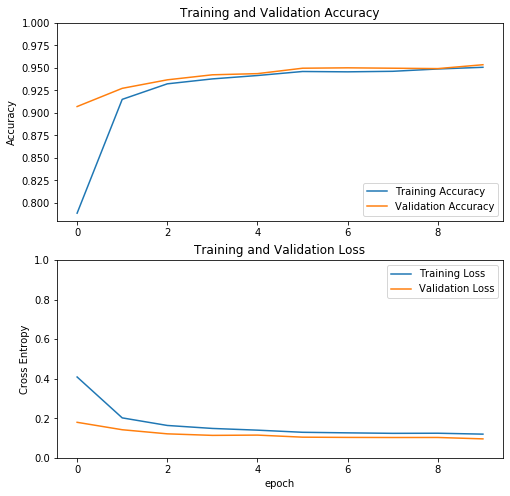

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()